# EDA HuBMAP + HPA - Hacking the Human Body

## Imports

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

import seaborn as sns

import tifffile
import cv2

## Dataframes

In [2]:
data_path = Path('../data')
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv']

In [3]:
train_df = pd.read_csv(data_path / 'train.csv')
test_df = pd.read_csv(data_path / 'test.csv')

In [4]:
train_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  
0    Male  
1    Male  
2    Male  
3    Male  
4  Female

In [5]:
train_df["area"] = train_df["img_height"] * train_df["img_height"]
train_df.head()

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex     area  
0    Male  9000000  
1    Male  9000000  
2    Male  9000000  
3    Male  9000000  
4  Female  9000000

In [6]:
test_df.head()

id   organ data_source  img_height  img_width  pixel_size  \
0  10078  spleen      Hubmap        2023       2023      0.4945   

   tissue_thickness  
0                 4

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
 10  area              351 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 30.3+ KB


In [8]:
train_df.describe()

id   img_height    img_width    pixel_size  tissue_thickness  \
count    351.000000   351.000000   351.000000  3.510000e+02             351.0   
mean   16662.914530  2978.364672  2978.364672  4.000000e-01               4.0   
std     9863.945557    90.962085    90.962085  2.612749e-15               0.0   
min       62.000000  2308.000000  2308.000000  4.000000e-01               4.0   
25%     8229.000000  3000.000000  3000.000000  4.000000e-01               4.0   
50%    16609.000000  3000.000000  3000.000000  4.000000e-01               4.0   
75%    25630.500000  3000.000000  3000.000000  4.000000e-01               4.0   
max    32741.000000  3070.000000  3070.000000  4.000000e-01               4.0   

              age          area  
count  351.000000  3.510000e+02  
mean    60.364672  8.878907e+06  
std     16.013327  5.038636e+05  
min     21.000000  5.326864e+06  
25%     55.000000  9.000000e+06  
50%     60.000000  9.000000e+06  
75%     73.000000  9.000000e+06  
max     84.000000  9.424900e+06

## Functions

In [9]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    return img.reshape(shape).T


def read_image_characteristics(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(str(data_path), f"train_images/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        print(f"[{image_id}] Train image shape: {image.shape}")
        image = image.squeeze().transpose(1, 2, 0)
    
    mask = rle2mask(
        train_df[train_df["id"] == image_id]["rle"].values[0], 
        (image.shape[1], image.shape[0])
    )
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
        print(f"[{image_id}] Mask shape: {mask.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
            print(f"[{image_id}] Resized Mask shape: {mask.shape}")
        
    return image, mask


def read_test_image(image_id, scale=None, verbose=1):
    image = tifffile.imread(
        os.path.join(str(data_path), f"test_images/{image_id}.tiff")
    )
    if len(image.shape) == 5:
        print(f"[{image_id}] Test image shape: {image.shape}")
        image = image.squeeze().transpose(1, 2, 0)
    
    if verbose:
        print(f"[{image_id}] Image shape: {image.shape}")
    
    if scale:
        new_size = (image.shape[1] // scale, image.shape[0] // scale)
        image = cv2.resize(image, new_size)
        
        if verbose:
            print(f"[{image_id}] Resized Image shape: {image.shape}")
        
    return image


def plot_image_and_mask(image, mask, image_id, cmap):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.grid(visible=False)
    plt.title(f"Image {image_id}", fontsize=18)
    
    plt.subplot(1, 3, 2)
    plt.imshow(image)
    plt.grid(visible=False)
    plt.imshow(mask, cmap=cmap, alpha=0.5)
    plt.title(f"Image {image_id} + mask", fontsize=18)    
    
    plt.subplot(1, 3, 3)
    plt.grid(visible=False)
    plt.imshow(mask, cmap=cmap)
    plt.title(f"Mask {image_id}", fontsize=18)    

    plt.show()
    
    
def plot_grid_image_with_mask(image, mask):
    plt.figure(figsize=(15, 15))
    
    w_len = image.shape[0]
    h_len = image.shape[1]
    
    min_len = min(w_len, h_len)
    w_start = (w_len - min_len) // 2
    h_start = (h_len - min_len) // 2
    
    plt.imshow(image[w_start : w_start + min_len, h_start : h_start + min_len])
    plt.imshow(
        mask[w_start : w_start + min_len, h_start : h_start + min_len], cmap="hot", alpha=0.5,
    )
    plt.axis("off")
            
    plt.show()
    

def plot_slice_image_and_mask(image, mask, start_h, end_h, start_w, end_w, cmap):
    plt.figure(figsize=(15, 5))
    
    sub_image = image[start_h:end_h, start_w:end_w, :]
    sub_mask = mask[start_h:end_h, start_w:end_w]
    
    plt.subplot(1, 3, 1)
    plt.imshow(sub_image)
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(sub_image)
    plt.imshow(sub_mask, cmap=cmap, alpha=0.5)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(sub_mask, cmap=cmap)
    plt.axis("off")
    
    plt.show()

## Visualizations

### Train Images

In [10]:
sampled_ids = [24782, 24522, 19360, 29238, 27232, 18792, 30424, 21812]
def get_image_masks_with_id(sampled_ids):
    sampled_images = []
    sampled_masks = []

    for sampled_id in sampled_ids:
        tmp_image, tmp_mask = read_image_characteristics(sampled_id, scale=20, verbose=0)
        sampled_images.append(tmp_image)
        sampled_masks.append(tmp_mask)
    
    return sampled_images, sampled_masks

Plot sampled train images

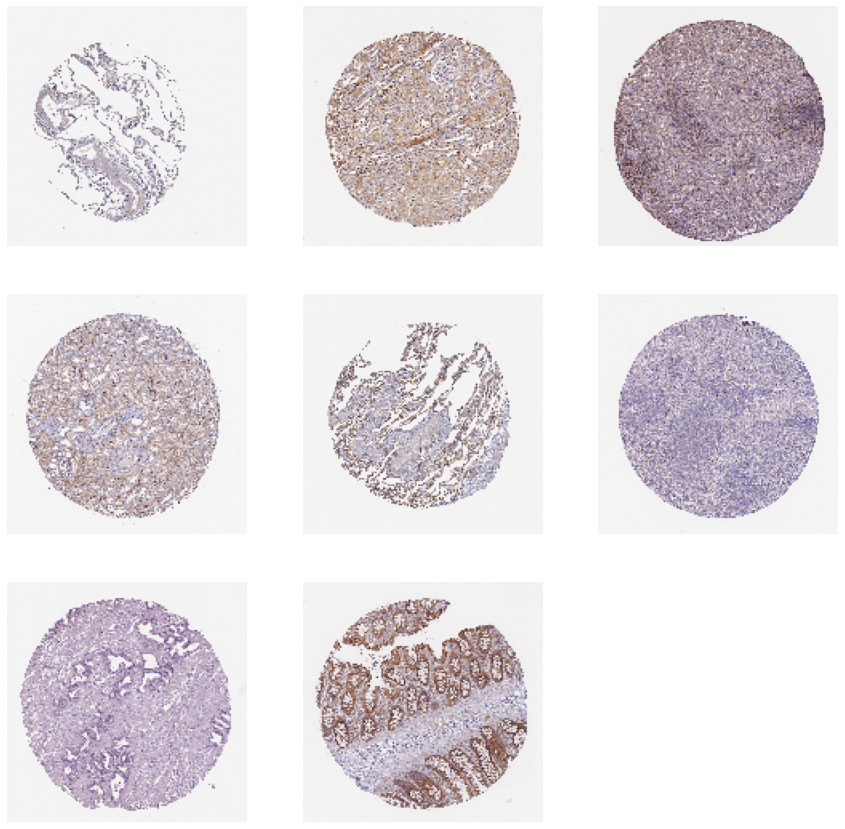

In [11]:
sampled_images, sampled_masks = get_image_masks_with_id(sampled_ids)

plt.figure(figsize=(15, 15))
for idx, tmp_img in enumerate(sampled_images):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(tmp_img)
    plt.axis("off")

In [14]:
img = sampled_images[0]
type(img), img.shape, img.dtype, img.max(), img.min()

(numpy.ndarray, (150, 150, 3), dtype('uint8'), 245, 34)

In [15]:
msk = sampled_masks[0]
type(msk), msk.shape, msk.dtype, msk.max(), msk.min()

(numpy.ndarray, (150, 150), dtype('uint8'), 1, 0)

0 means not tissue unit (FTU) and 1 means tissue unit (FTU)

In [17]:
# one-hot encoding
msk_oh = (np.arange(msk.max()+1) == msk[...,None]).astype(np.float32) 

msk_oh.shape, msk_oh.dtype, msk_oh.max(), msk_oh.min()

((150, 150, 2), dtype('float32'), 1.0, 0.0)

Plot sampled train images with masks

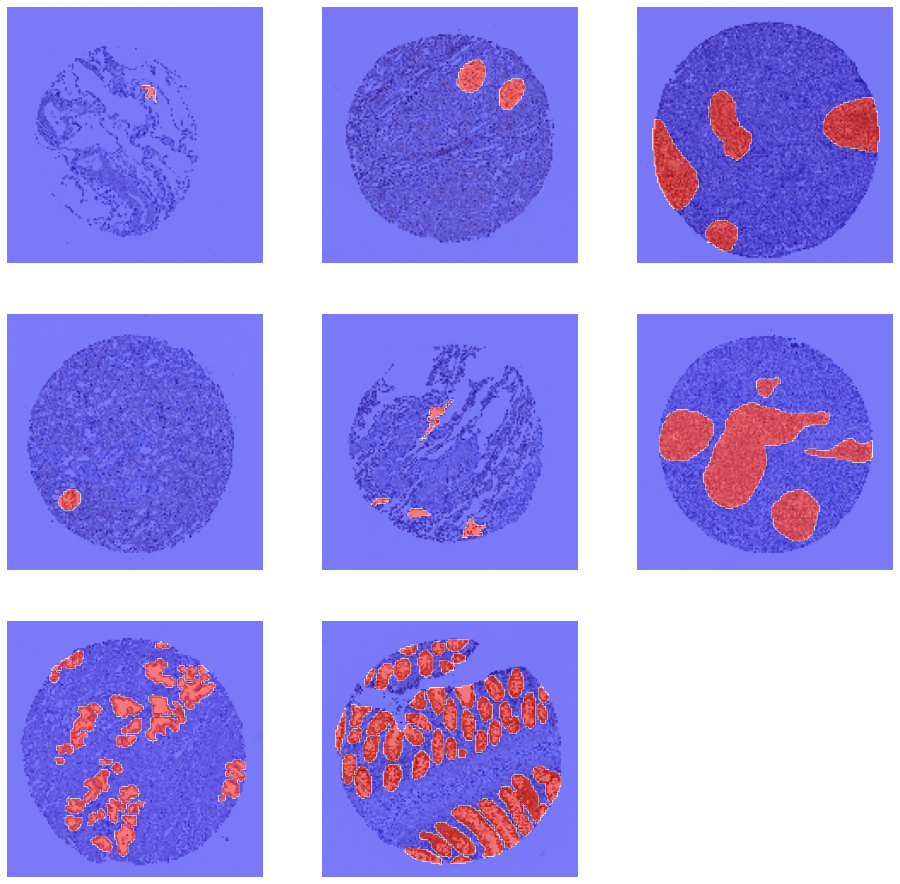

In [24]:
plt.figure(figsize=(15, 15))
for idx, (tmp_image, tmp_mask) in enumerate(zip(sampled_images, sampled_masks)):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(tmp_image)
    plt.imshow(tmp_mask, cmap="bwr", alpha=0.5)
    plt.axis("off")

### Test Image

(-0.5, 1010.5, 1010.5, -0.5)

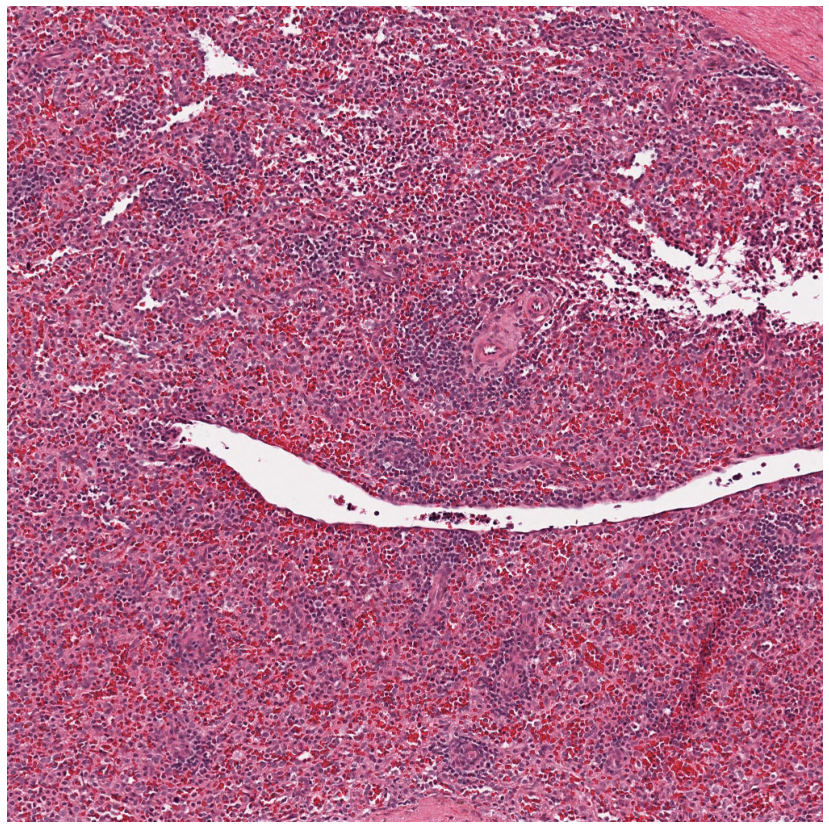

In [30]:
image_id = 10078
test_image = read_test_image(image_id, scale=2, verbose=0)

plt.figure(figsize=(15, 15))
plt.imshow(test_image)
plt.axis("off")

## Detailed view of train Image

### Spleen Male (bazo hombre) - idx 19360

Get image characteristics

In [33]:
idx = 19360
image, mask = read_image_characteristics(idx, 2)

[19360] Image shape: (3000, 3000, 3)
[19360] Mask shape: (3000, 3000)
[19360] Resized Image shape: (1500, 1500, 3)
[19360] Resized Mask shape: (1500, 1500)


Plot image and mask

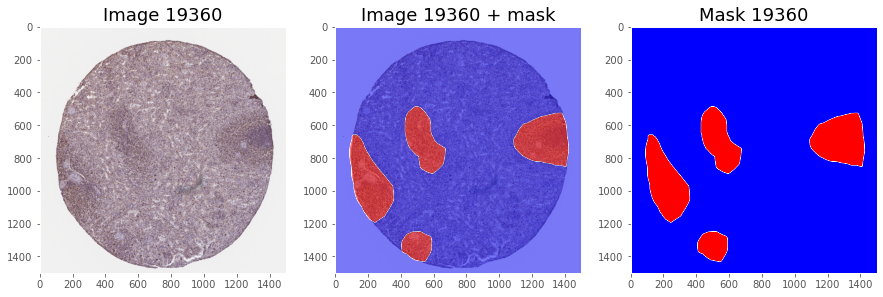

In [36]:
plot_image_and_mask(image, mask, idx, "bwr")

Plot slices of masks

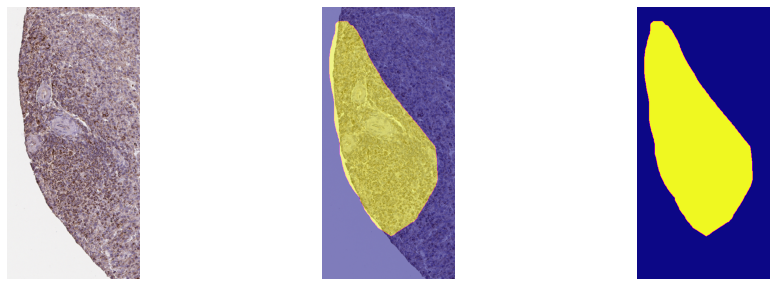

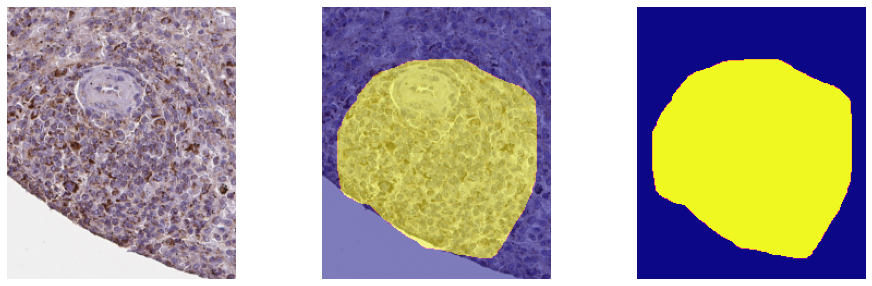

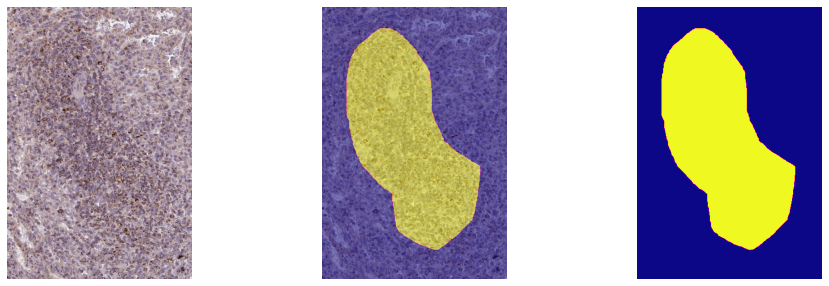

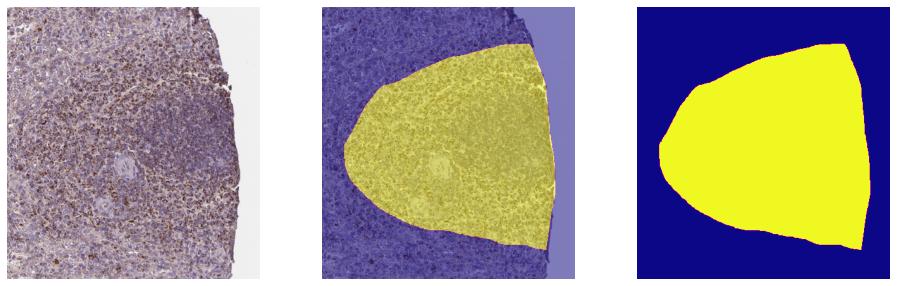

In [38]:
plot_slice_image_and_mask(image, mask, 625, 1300, 70, 400, "plasma")
plot_slice_image_and_mask(image, mask, 1200, 1450, 390, 600, "plasma")
plot_slice_image_and_mask(image, mask, 450, 950, 380, 720, "plasma")
plot_slice_image_and_mask(image, mask, 470, 900, 1050, 1450, "plasma")

Plot grid of image with mask

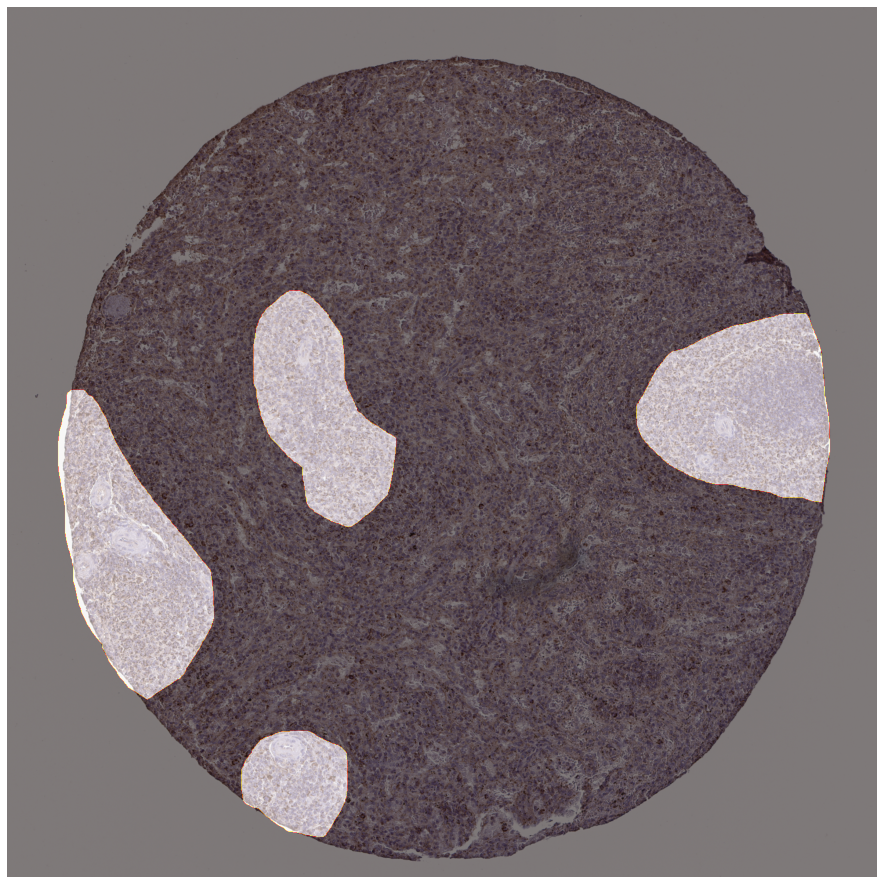

In [39]:
plot_grid_image_with_mask(image, mask)

## Analyzing the Meta Data

In [44]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
 10  area              351 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 30.3+ KB


In [45]:
train_df.describe()

id   img_height    img_width    pixel_size  tissue_thickness  \
count    351.000000   351.000000   351.000000  3.510000e+02             351.0   
mean   16662.914530  2978.364672  2978.364672  4.000000e-01               4.0   
std     9863.945557    90.962085    90.962085  2.612749e-15               0.0   
min       62.000000  2308.000000  2308.000000  4.000000e-01               4.0   
25%     8229.000000  3000.000000  3000.000000  4.000000e-01               4.0   
50%    16609.000000  3000.000000  3000.000000  4.000000e-01               4.0   
75%    25630.500000  3000.000000  3000.000000  4.000000e-01               4.0   
max    32741.000000  3070.000000  3070.000000  4.000000e-01               4.0   

              age          area  
count  351.000000  3.510000e+02  
mean    60.364672  8.878907e+06  
std     16.013327  5.038636e+05  
min     21.000000  5.326864e+06  
25%     55.000000  9.000000e+06  
50%     60.000000  9.000000e+06  
75%     73.000000  9.000000e+06  
max     84.000000  9.424900e+06

Train data over organs

<AxesSubplot:>

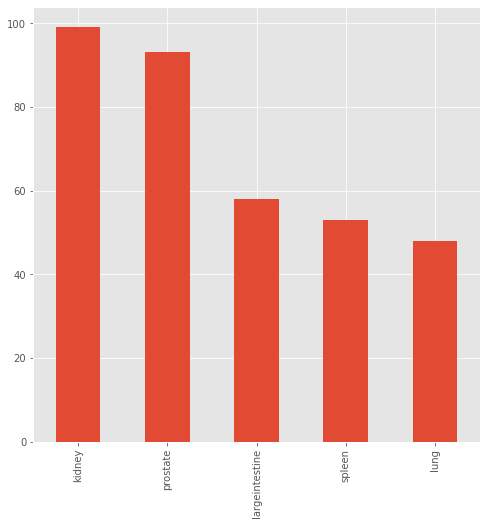

In [46]:
plt.figure(figsize=(8, 8))
train_df.organ.value_counts().plot(kind='bar')

Train data over sex

<AxesSubplot:>

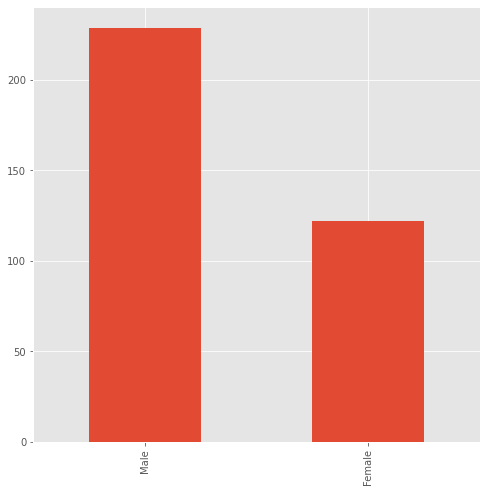

In [47]:
plt.figure(figsize=(8, 8))
train_df.sex.value_counts().plot(kind='bar')

Train data over source

<AxesSubplot:>

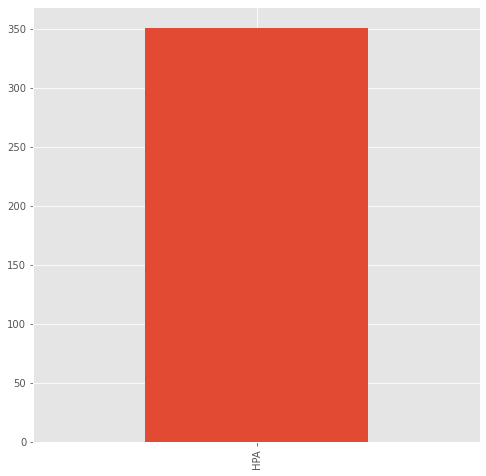

In [48]:
plt.figure(figsize=(8, 8))
train_df.data_source.value_counts().plot(kind='bar')

Histogram over age

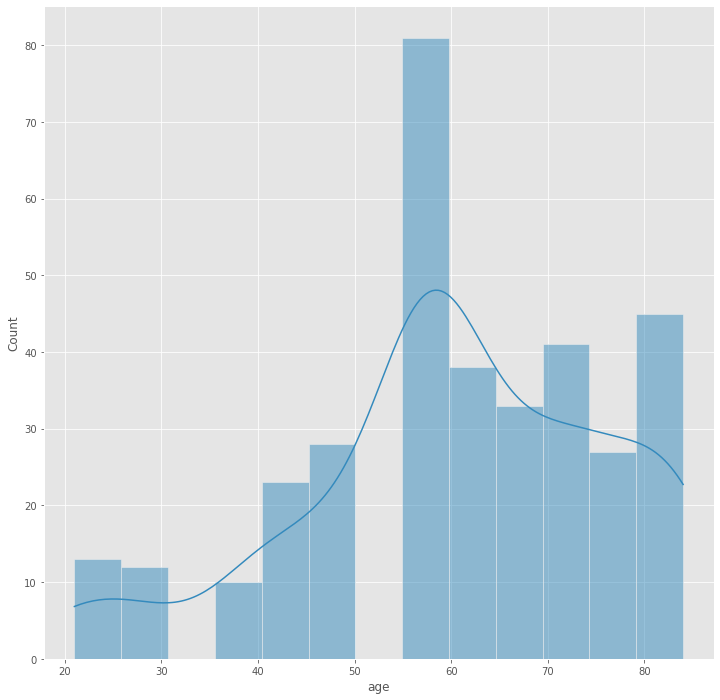

In [49]:
plt.figure(figsize=(12, 12))
sns.histplot(x="age", kde=True, data=train_df)
plt.show()

Histogram over sex and age

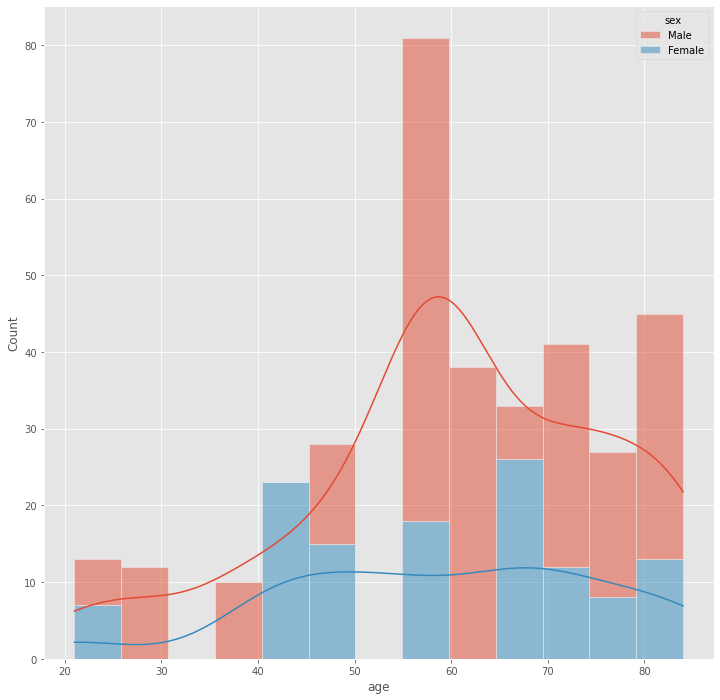

In [50]:
plt.figure(figsize=(12, 12))
sns.histplot(x="age", hue="sex", multiple="stack", kde=True, data=train_df)
plt.show()

Histogram over organ and age

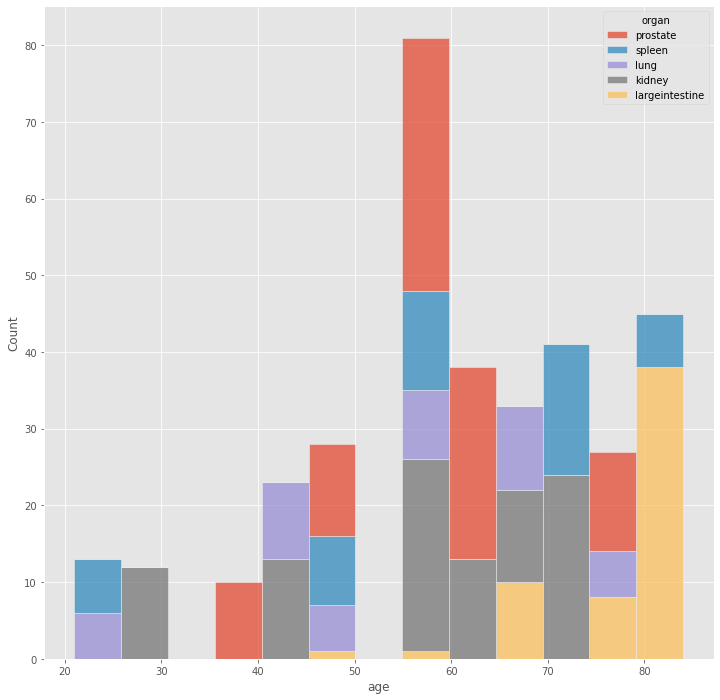

In [51]:
plt.figure(figsize=(12, 12))
sns.histplot(x="age", hue="organ", multiple="stack", data=train_df)
plt.show()

<Figure size 864x864 with 0 Axes>

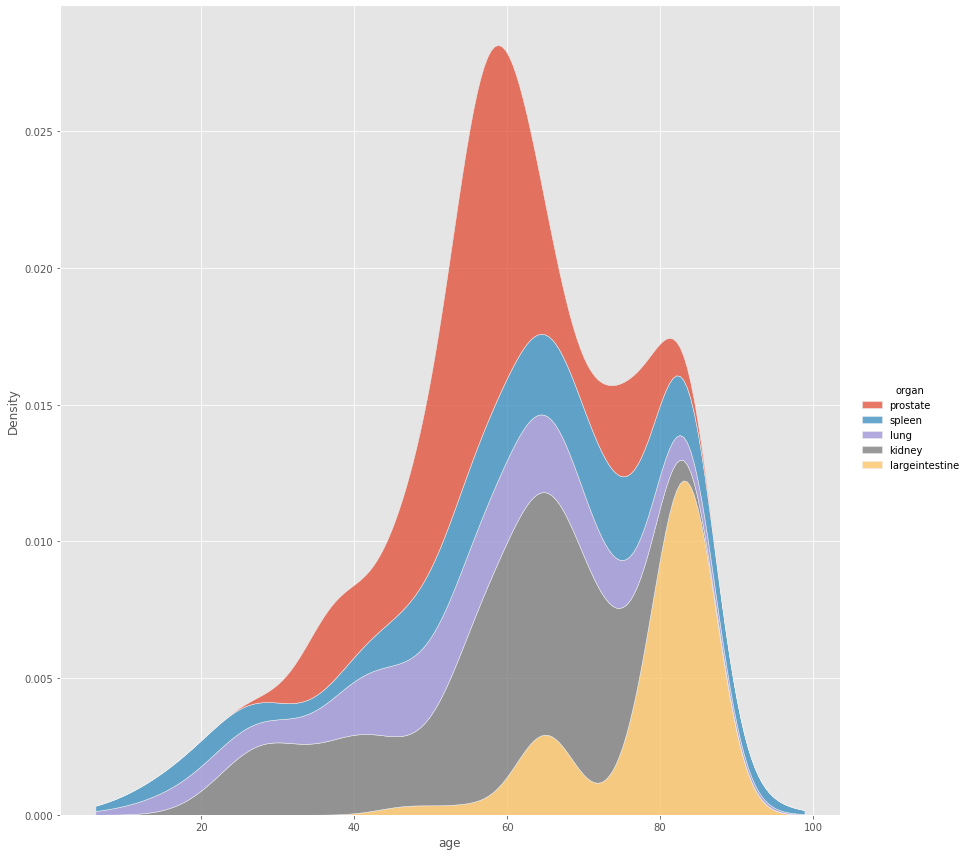

In [52]:
plt.figure(figsize=(12, 12))
sns.displot(x="age", hue="organ", kind="kde", multiple='stack', data=train_df, height=12)

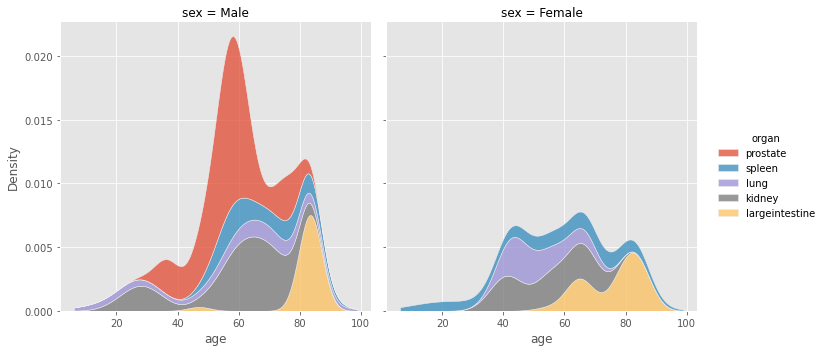

In [53]:
sns.displot(x="age", col="sex", hue="organ", kind="kde", multiple='stack', data=train_df)

Histogram over organ and sex

<AxesSubplot:xlabel='organ', ylabel='count'>

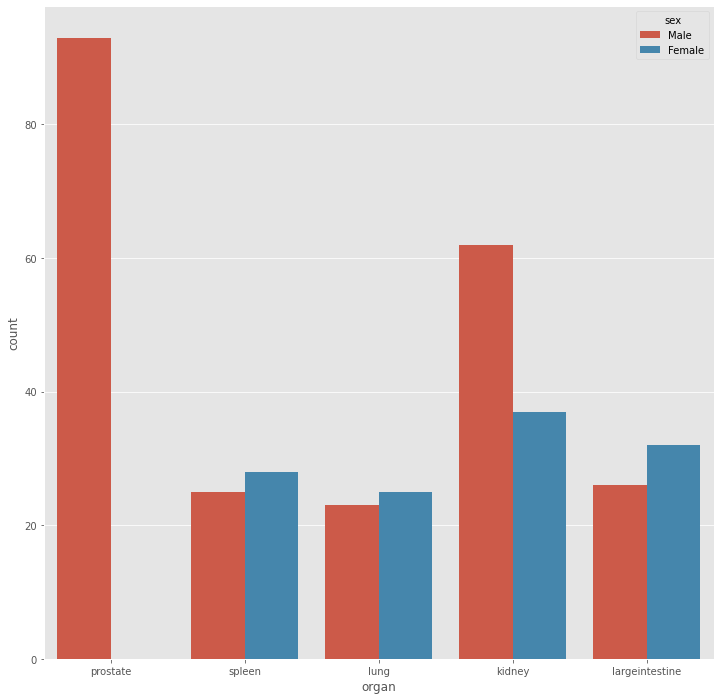

In [54]:
plt.figure(figsize=(12, 12))
sns.countplot(x="organ", hue="sex", data=train_df)

Histogram over organ and source

<AxesSubplot:xlabel='organ', ylabel='count'>

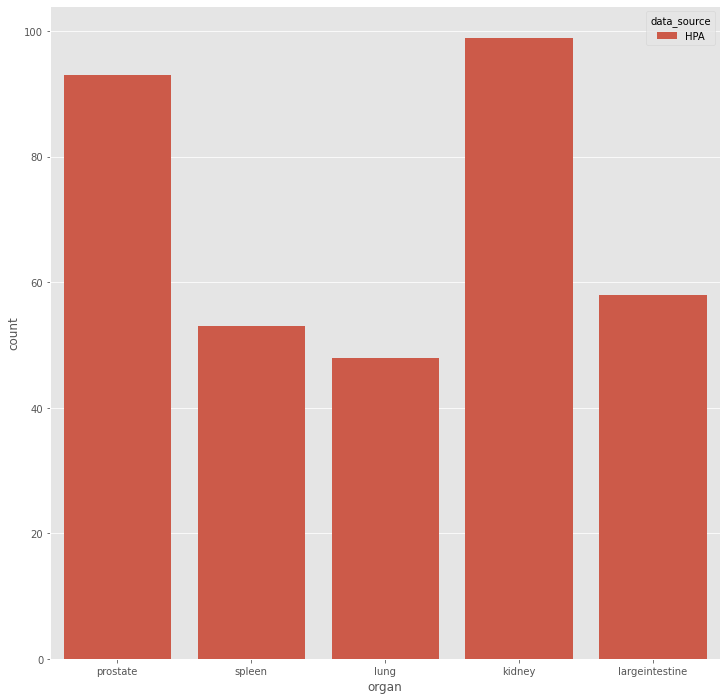

In [55]:
plt.figure(figsize=(12, 12))
sns.countplot(x="organ", hue="data_source", data=train_df)